# Feature CNN

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

column_names = ['style', 'gen'] + [f'feature_{i}' for i in range(256)]

# Step 1: Load the CSV file
ai_ld_tr = pd.read_csv('train/AI_LD_realism.csv', header=None)
ai_ld_tr.columns = column_names
print(ai_ld_tr.isna().sum().sum())

ai_sd_tr = pd.read_csv('train/AI_SD_realism.csv', header=None)
ai_sd_tr.columns = column_names
print(ai_sd_tr.isna().sum().sum())

hu_tr = pd.read_csv('train/realism.csv', header=None)
hu_tr.columns = column_names
print(hu_tr.isna().sum().sum())

#sample required number of rows
ai_ld_tr = ai_ld_tr.sample(n=250, random_state=None)
ai_sd_tr = ai_sd_tr.sample(n=250, random_state=None)
hu_tr = hu_tr.sample(n=500, random_state=None)  # Adjusted to sample 500 rows

train = pd.concat([ai_ld_tr, ai_sd_tr, hu_tr], ignore_index=True)
train.drop("style", axis=1, inplace=True)
train['gen'] = train['gen'].apply(lambda x: 1 if x == 'HU' else 0)
print(train.iloc[:, 0])


0
0
0
0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Name: gen, Length: 1000, dtype: int64


In [2]:
ai_ld_ts = pd.read_csv('test/AI_LD_realism.csv', header=None)
ai_ld_ts.columns = column_names
print(ai_ld_ts.isna().sum().sum())

ai_sd_ts = pd.read_csv('test/AI_SD_realism.csv', header=None)
ai_sd_ts.columns = column_names
print(ai_sd_ts.isna().sum().sum())

hu_ts = pd.read_csv('test/realism.csv', header=None)
hu_ts.columns = column_names
print(hu_ts.isna().sum().sum())

#sample required number of rows
ai_ld_ts = ai_ld_ts.sample(n=250, random_state=None)
ai_sd_ts = ai_sd_ts.sample(n=250, random_state=None)
hu_ts = hu_ts.sample(n=500, random_state=None)  # Adjusted to sample 500 rows

test = pd.concat([ai_ld_ts, ai_sd_ts, hu_ts], ignore_index=True)
test.drop("style", axis=1, inplace=True)
test['gen'] = test['gen'].apply(lambda x: 1 if x == 'HU' else 0)
print(test.iloc[:, 0])

0
0
0
0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Name: gen, Length: 1000, dtype: int64


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

tr_labels = train.iloc[:, 0]
tr_features = train.iloc[:, 1:]

X_train, X_val, y_train, y_val = train_test_split(tr_features, tr_labels, test_size=0.2, random_state=42)

encoder = LabelEncoder()
y_train = to_categorical(encoder.fit_transform(y_train))
y_val = to_categorical(encoder.transform(y_val))

In [4]:
ts_labels = test.iloc[:, 0]
X_test = test.iloc[:, 1:]

encoder = LabelEncoder()
y_test = to_categorical(encoder.fit_transform(ts_labels))

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Define the neural network architecture
def create_model():
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(256, 1)),  # Convolutional layer with 32 filters and kernel size 3
        MaxPooling1D(2),                                         # Max pooling layer
        Conv1D(16, 3, activation='relu'),                        # Additional convolutional layer with 16 filters and kernel size 3
        MaxPooling1D(2),                                         # Additional max pooling layer
        Flatten(),                                               # Flatten layer
        Dense(64, activation='relu'),                            # Fully connected layer with 64 neurons
        Dropout(0.5),                                            # Dropout layer to reduce overfitting
        Dense(2, activation='sigmoid')                           # Output layer with 2 neurons (assuming binary classification)
    ])
    return model

model = create_model()


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [6]:
# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate if needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("CNN_feat_realism.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, callbacks=[checkpoint, early_stopping])

Epoch 1/40
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5173 - loss: 0.7579
Epoch 1: val_accuracy improved from -inf to 0.78000, saving model to CNN_feat_realism.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5262 - loss: 0.7465 - val_accuracy: 0.7800 - val_loss: 0.5948
Epoch 2/40
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6851 - loss: 0.6111
Epoch 2: val_accuracy improved from 0.78000 to 0.87500, saving model to CNN_feat_realism.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6954 - loss: 0.6022 - val_accuracy: 0.8750 - val_loss: 0.4318
Epoch 3/40
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7939 - loss: 0.4997
Epoch 3: val_accuracy improved from 0.87500 to 0.89000, saving model to CNN_feat_realism.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7943 - loss: 0.4980 - val_accuracy: 0.8900 - val_loss: 0.3550
Epoch 4/40
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8012 - loss: 0.4700
Epoch 4: val_accuracy improved fro

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9085 - loss: 0.1915 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Validation Accuracy: 0.92


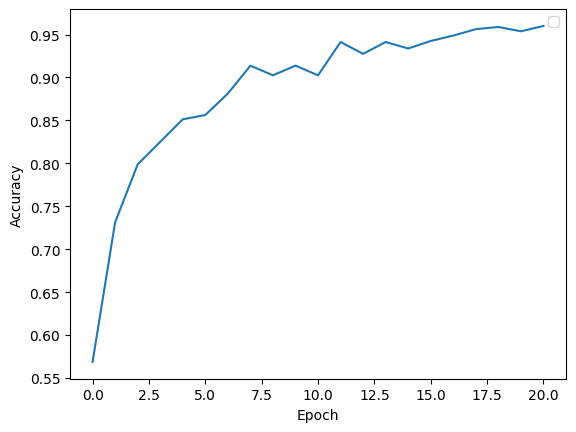

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy:.2f}')

# Plot training history
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
predictions = model.predict(X_test)

# Evaluate the predictions using appropriate metrics
# For classification tasks
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Test Accuracy: {accuracy:.2f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1828 - loss: 2.9868
Test Accuracy: 0.47
